### Code to demo the REINFORCE with Baseline model

Last updated 3/21/2025

---

Baseline is included to help stabilize training.

- Draft code sourced from ChatGPT
  - Needed to make edits for things to run:
    1.
      import gym  
      to  
      import gymnasium as gym

    2.  
      state = env.reset()  
      to  
      state = env.reset()[0]

    3.  next_state, reward, done, _ = env.step(action)       
        to  
        next_state, reward, terminated, truncated, _ = env.step(action)  
        done = terminated or truncated

    4. several suggested changes to handle state variable properly

  ---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
import matplotlib.pyplot as plt

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        action_probs = F.softmax(self.fc2(x), dim=-1)
        return action_probs

class BaselineNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(BaselineNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1) # outputs value function

    def forward(self, state):
        x = F.relu(self.fc1(state))
        baseline = self.fc2(x)
        return baseline

class REINFORCE:
    def __init__(self, state_dim, action_dim, learning_rate=0.01, baseline_lr=0.01):
        self.policy_network = PolicyNetwork(state_dim, action_dim)
        self.baseline_network = BaselineNetwork(state_dim)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        self.baseline_optimizer = optim.Adam(self.baseline_network.parameters(), lr=baseline_lr)
        self.log_probs = []
        self.rewards = []
        self.losses = []
        # Store states for baseline calculation
        self.states = []


    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32) if not isinstance(state, torch.Tensor) else state
        action_probs = self.policy_network(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        self.log_probs.append(action_dist.log_prob(action))
        return action.item()

    def store_reward(self, reward):
        self.rewards.append(reward)
        self.states.append(state) # Store state along with reward

    def update_policy(self, gamma=0.99):
        discounted_rewards = []
        R = 0
        for r in reversed(self.rewards):
            R = r + gamma * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.tensor(discounted_rewards)

        # normalize rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        loss = 0
        baseline_loss = 0
        for i, (log_prob, reward) in enumerate(zip(self.log_probs, discounted_rewards)):
            state = torch.tensor(self.states[i], dtype=torch.float32) # Use stored state
            baseline = self.baseline_network(self.states[i].clone().detach()).squeeze()
            advantage = reward - baseline.item()

            # minimize negative grad log_prob x advantage.
            # negative because optimizers use gradient descent but we want gradient ascent
            loss -= log_prob * advantage

            # minimize MSE of baseline
            baseline_loss += F.mse_loss(baseline, reward.clone().detach().unsqueeze(0))


        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.baseline_optimizer.zero_grad()
        baseline_loss.backward()
        self.baseline_optimizer.step()

        self.losses.append(loss.item())
        self.log_probs = []
        self.rewards = []
        self.states = []  # Reset states

    def plot_losses(self):
        plt.plot(self.losses)
        plt.xlabel("Episodes")
        plt.ylabel("Loss")
        plt.title("REINFORCE with Baseline Loss Over Time")
        plt.show()

<ipython-input-2-d9fad64dc864>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(self.states[i], dtype=torch.float32) # Use stored state
<ipython-input-2-d9fad64dc864>:71: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  baseline_loss += F.mse_loss(baseline, reward.clone().detach().unsqueeze(0))


Episode 1/500, Reward: 16.0
Episode 11/500, Reward: 21.0
Episode 21/500, Reward: 17.0
Episode 31/500, Reward: 140.0
Episode 41/500, Reward: 183.0
Episode 51/500, Reward: 85.0
Episode 61/500, Reward: 203.0
Episode 71/500, Reward: 301.0
Episode 81/500, Reward: 148.0
Episode 91/500, Reward: 288.0
Episode 101/500, Reward: 262.0
Episode 111/500, Reward: 500.0
Episode 121/500, Reward: 500.0
Episode 131/500, Reward: 500.0
Episode 141/500, Reward: 148.0
Episode 151/500, Reward: 500.0
Episode 161/500, Reward: 500.0
Episode 171/500, Reward: 500.0
Episode 181/500, Reward: 326.0
Episode 191/500, Reward: 500.0
Episode 201/500, Reward: 500.0
Episode 211/500, Reward: 500.0
Episode 221/500, Reward: 500.0
Episode 231/500, Reward: 500.0
Episode 241/500, Reward: 243.0
Episode 251/500, Reward: 190.0
Episode 261/500, Reward: 165.0
Episode 271/500, Reward: 500.0
Episode 281/500, Reward: 500.0
Episode 291/500, Reward: 500.0
Episode 301/500, Reward: 500.0
Episode 311/500, Reward: 500.0
Episode 321/500, Reward

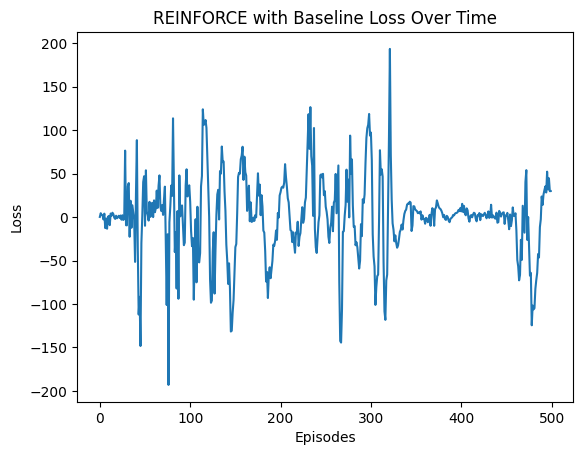

In [ ]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = REINFORCE(state_dim, action_dim)
episodes = 500
for episode in range(episodes):
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32)
    episode_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = terminated or truncated
        agent.store_reward(reward)
        episode_reward += reward
        state = next_state

    agent.update_policy()
    if episode % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}, Reward: {episode_reward}")

agent.plot_losses()
env.close()


Notice that episode rewards are more consistent, and they stay high faster when compared to standard REINFORCE.